# 批量规范化
训练深层神经网络是十分困难的，特别是在较短的时间内使他们收敛更加棘手。本节将介绍批量规范化（batch
normalization）(Ioffe and Szegedy, 2015)，这是一种流行且有效的技术，可持续加速深层网络的收敛速度。

## 训练深层网络
为什么需要批量规范化？训练神经网络时出现的一些实际挑战

1. 数据预处理的方式通常会对最终结果产生巨大影响。使用真实数据之前，第一步是标准化输入特征，使其均值为0， 方差为1.
1. 对于典型的多层感知机或卷积神经网络，当训练的时候，中间层的变量可能具有更广的变化范围。
1. 更深层的网络很复杂，很容易过拟合。正则化变得更加重要。

从形式上说，用 $\mathbf{x} \in \mathcal{B}$ 表示一个来自小批量 $\mathcal{B}$ 的输入，批量规范化 $\mathrm{BN}$ 根据一下表达式转换 $\mathbf{x}$:
$$    
    \mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}. 
$$


其中 $\hat{\boldsymbol{\mu}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本均值， $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ 是小批量 $\mathcal{B}$ 的样本标准差。$\boldsymbol{\gamma}$ 是拉伸参数 $\boldsymbol{\beta}$ 是偏移参数， 它们的形状与 $\mathbf{x}$ 相同。

请注意，$\boldsymbol{\gamma}$ 和 $\boldsymbol{\beta}$ 是需要与其他模型一起学习的参数。

从形式上看，计算 $\hat{\boldsymbol{\mu}}_{\mathcal{B}}$ 和 $\hat{\boldsymbol{\sigma}}_{\mathcal{B}}^{2}$，如下所示：
$$
    \hat{\boldsymbol{\mu}}_{\mathcal{B}} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x}, \\
$$
$$
    \hat{\boldsymbol{\sigma}}_{\mathcal{B}}^{2} = \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.
$$

现在，我们了解一下批量规范化在实践中是如何工作的:

## 批量规范化层

批量规范化和其他层之间的一个关键区别是，由于批量规范化在完整的小批量上运行，因此我们
不能像以前在引入其他层时那样忽略批量大小。

我们在下面讨论这两种情况：全连接层和卷积层，他们的批
量规范化实现略有不同。

### 全连接层


通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为 $\mathbf{x}$ ，权重参数和偏置参数分别为 $\mathbf{W}$ 和 $\mathbf{b}$ ，激活函数为 $\phi$ ，批量规范化的运算符为 $BN$ 。那么，使用批量规范化的全连接层的输出计算详情如下：
$$
    \mathbf{h} = \phi (BN(\mathbf{Wx} + \mathbf{b})).
$$

### 卷积层
对于卷积层，我们可以在卷积层之后和非线性激活函数几千应用批量规范化。如果卷积有多个输出通道时，需要对这些通道的"每个"输出执行批量规范化。

### 预测过程中的批量规范化
首先，将训练好的模型用于预
测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。其次，例如，我
们可能需要使用我们的模型对逐个样本进行预测。一种常用的方法是通过移动平均估算整个训练数据集的样
本均值和方差，并在预测时使用它们得到确定的输出。可见，和暂退法一样，批量规范化层在训练模式和预
测模式下的计算结果也是不一样的。

## 从零实现批量规范化

In [5]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

In [6]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 使用批量规范化层的LeNet

批量规范化实在卷积层或全连接层之后、相应的激活函数之前应用的。

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

和之前的LeNet训练一样，只是学习率大得多

loss 0.272, train acc 0.899, test acc 0.878
45433.7 examples/sec on cuda:0


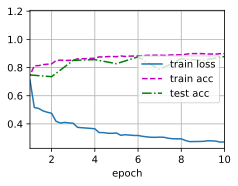

In [8]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

看看从第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta。

In [9]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([3.1178, 2.2260, 3.0187, 3.6854, 2.5935, 2.0287], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.0999, -2.7132, -3.0565, -2.4970, -1.3944,  1.0630], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

## 简明实现

loss 0.267, train acc 0.901, test acc 0.874
73942.4 examples/sec on cuda:0


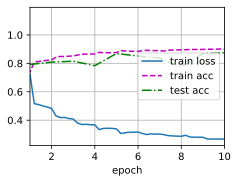

In [10]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())